# WIDS Predict Hospital Fatality

Table of Contents:

1. Import Libriaries/packages
2. Explore Data
3. Preprocess data
4. Model
5. Evaluate

In [114]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\samplesubmission.csv
./input\solution_template.csv
./input\training_v2.csv
./input\unlabeled.csv
./input\WiDS Datathon 2020 Dictionary.csv


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# additional experiement packages
import missingno as msno

%matplotlib inline

# pd.options.display.max_columns = None
# pd.options.display.max_row = 5

OptionError: 'You can only set the value of existing options'

## Load Data

In [116]:
# loading dataset 
training_v2 = pd.read_csv("./input/training_v2.csv")
solution_template = pd.read_csv("./input/solution_template.csv")
samplesubmission = pd.read_csv("./input/samplesubmission.csv")
unlabeled = pd.read_csv("./input/unlabeled.csv")
dictionary = pd.read_csv("./input/WiDS Datathon 2020 Dictionary.csv")

In [117]:
df = training_v2.copy()

In [118]:
training_v2.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [119]:
training_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [120]:
solution_template.head()

,encounter_id,hospital_death
0,2,NaN
1,5,NaN
2,7,NaN
3,8,NaN
4,10,NaN


In [121]:
samplesubmission.head()

,encounter_id,hospital_death
0,2,0.500
1,5,0.200
2,7,0.001


In [122]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [123]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


In [124]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


## 3. Preprocessing

### Experiment with missingno package

repo: https://github.com/ResidentMario/missingno

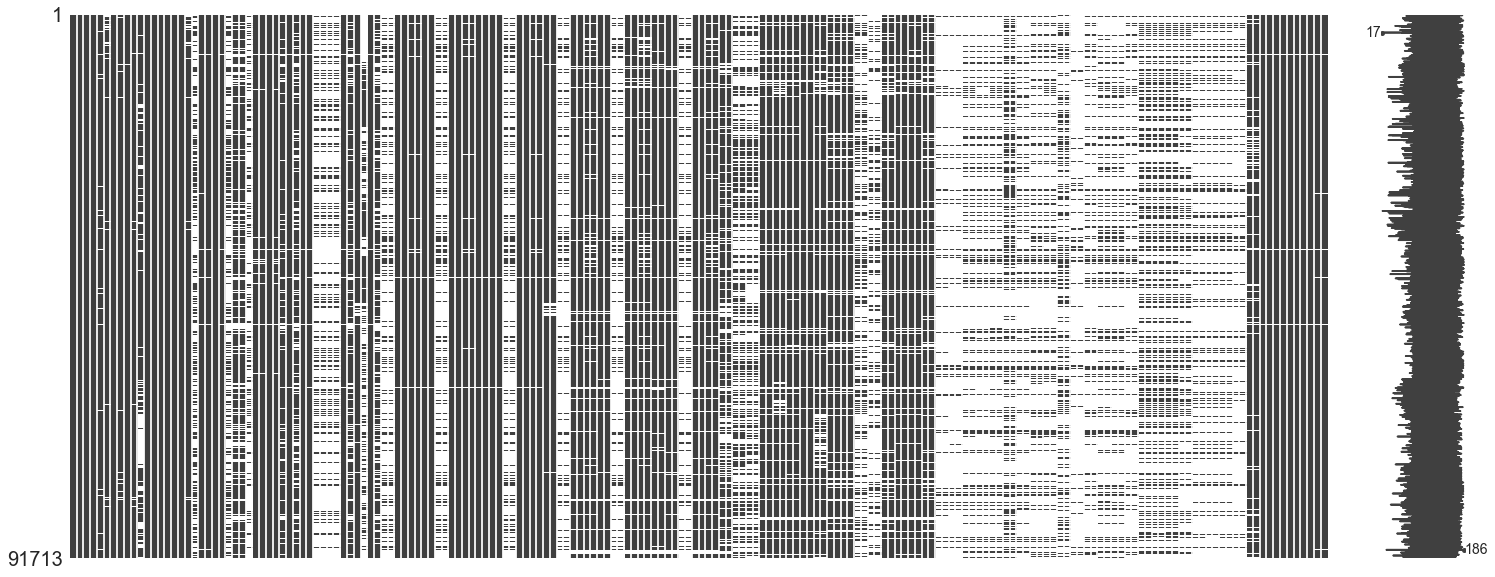

In [125]:
msno.matrix(training_v2)

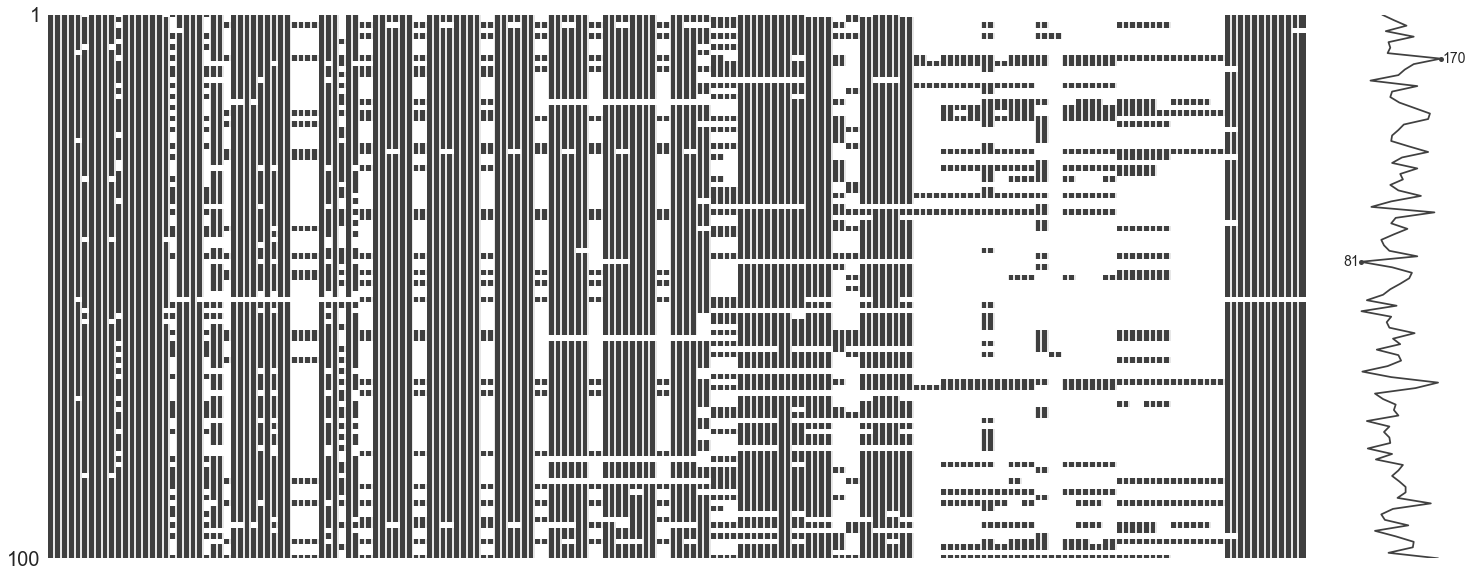

In [126]:
msno.matrix(training_v2.sample(100))

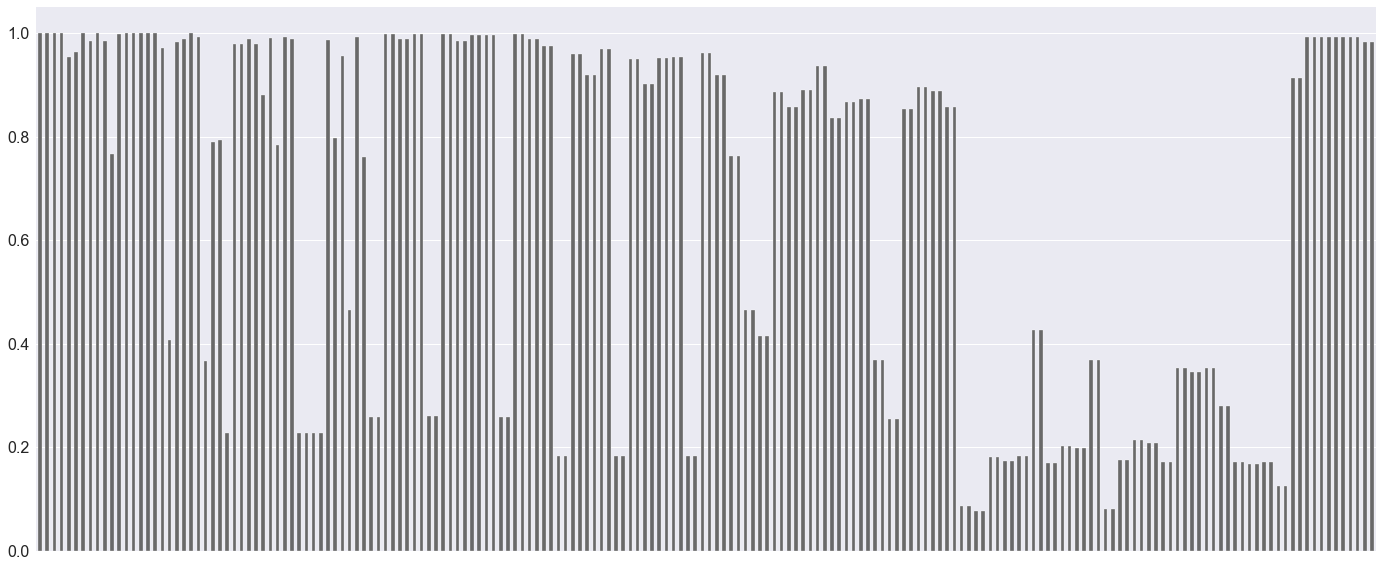

In [127]:
msno.bar(training_v2)

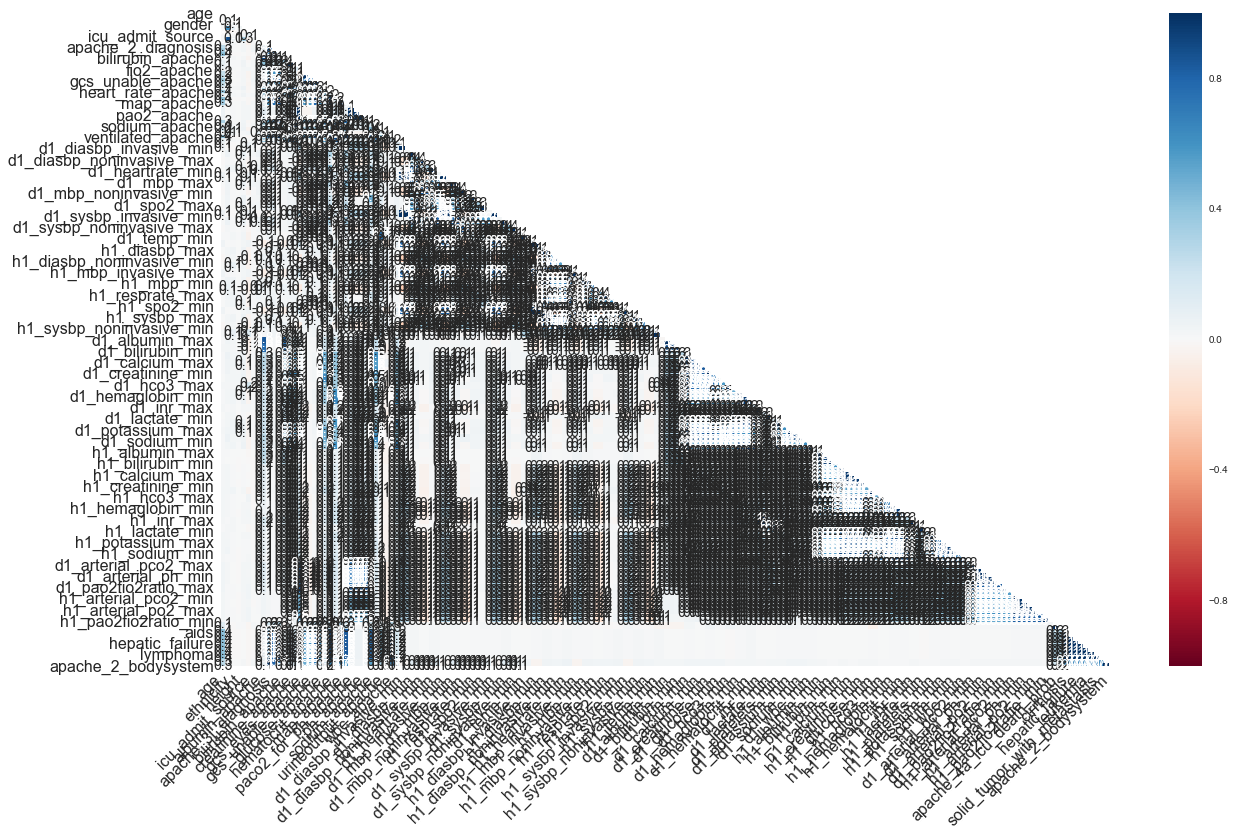

In [128]:
msno.heatmap(training_v2)

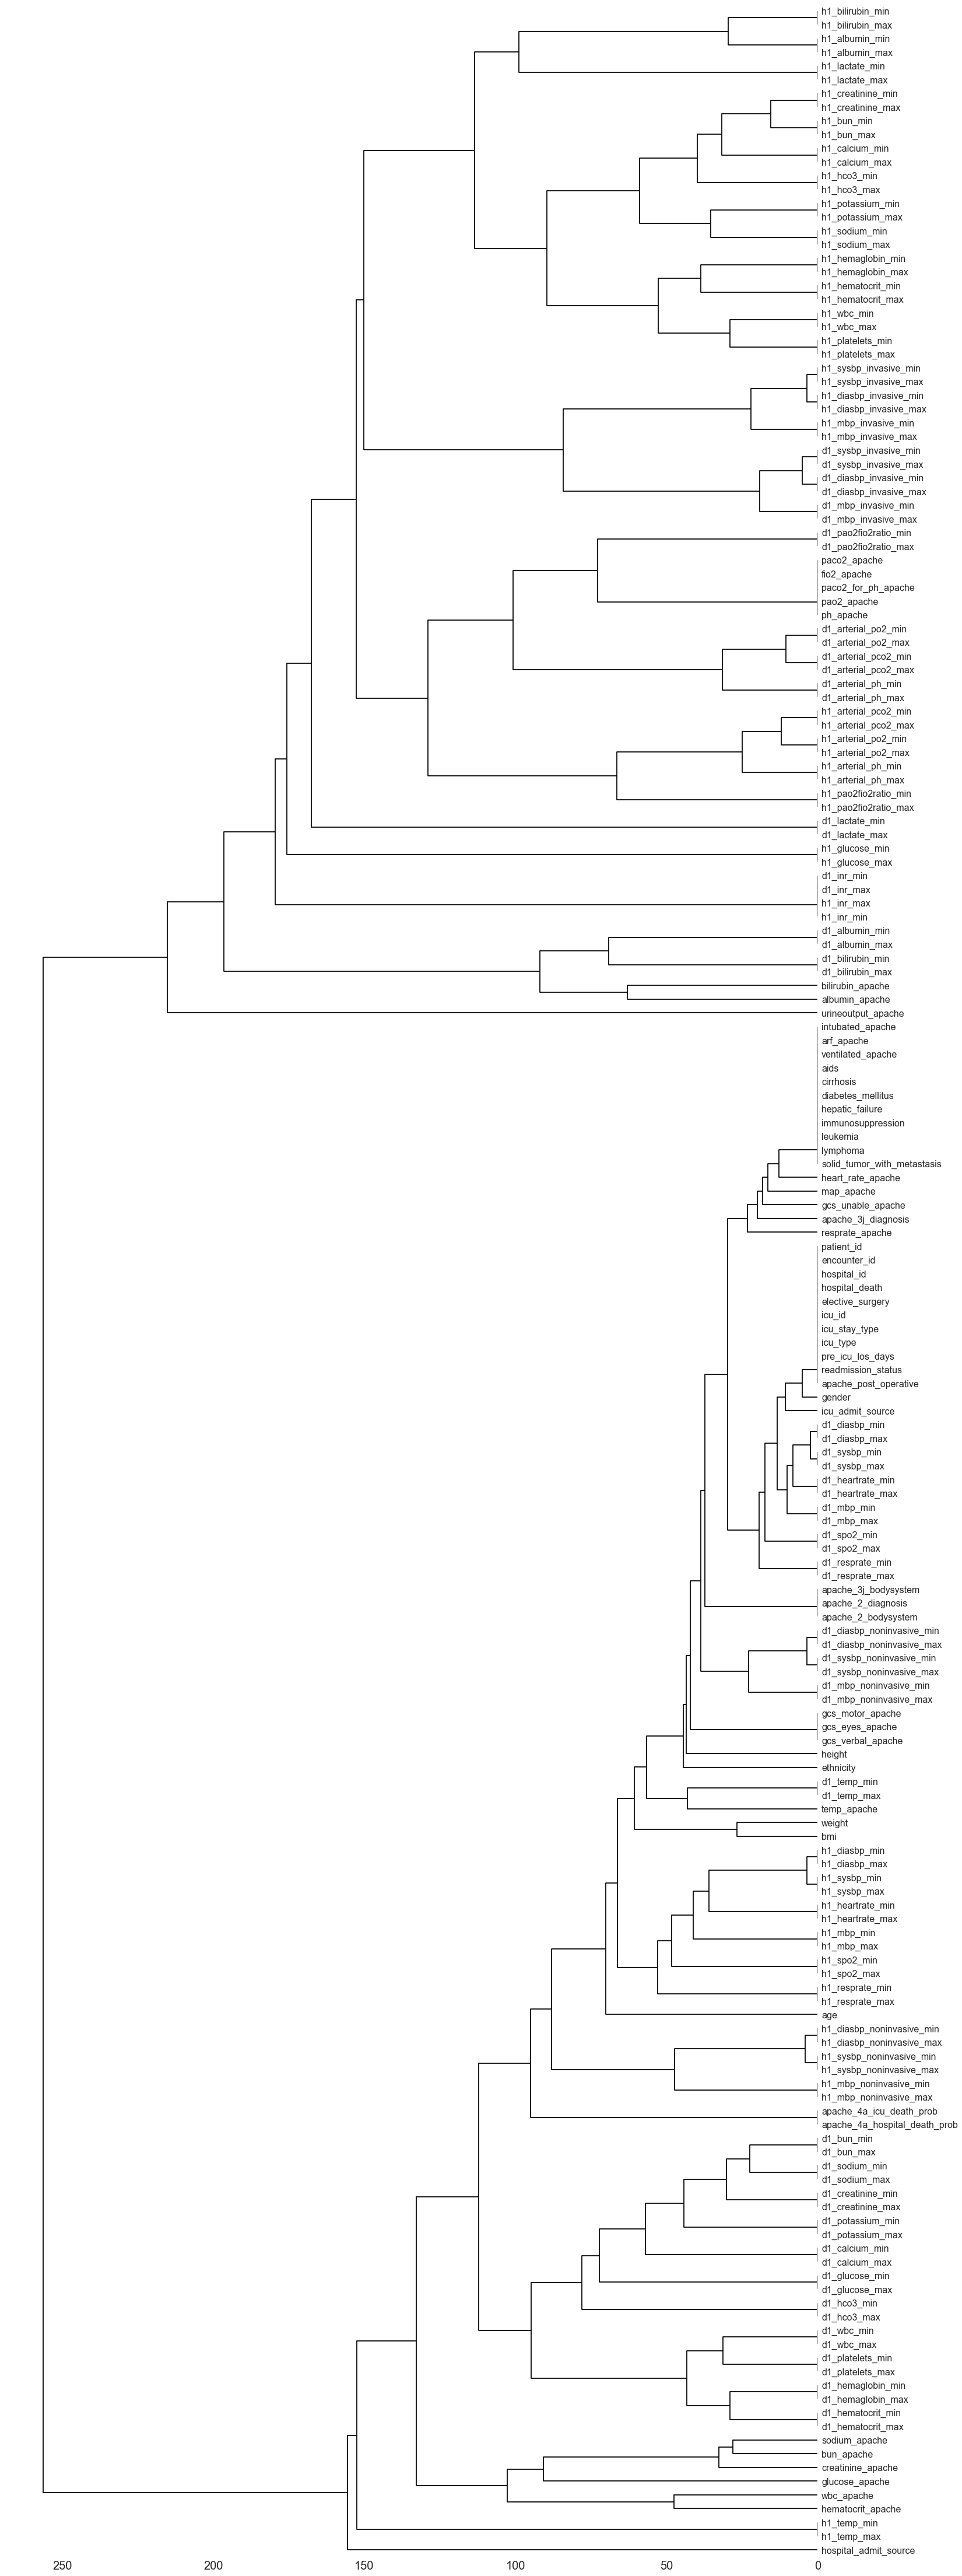

In [129]:
>>> msno.dendrogram(training_v2)


Text(0.5, 1.0, 'Columns with Missing values')

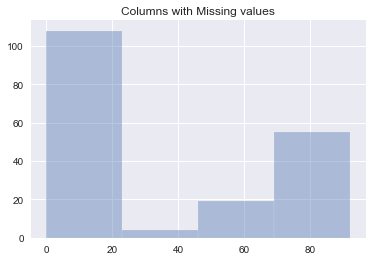

In [130]:
sns.distplot((((df.isnull().sum()/df.shape[0]).sort_values(ascending=False)*100)), kde=False)
plt.title('Columns with Missing values')

## DABL

In [131]:
import dabl

In [132]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Target looks like classification
Showing only top 10 of 160 continuous features
Linear Discriminant Analysis training set score: 0.673


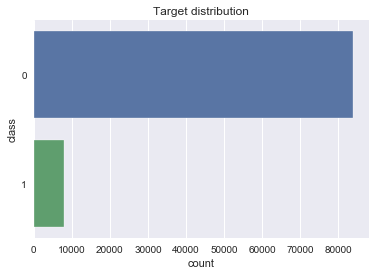

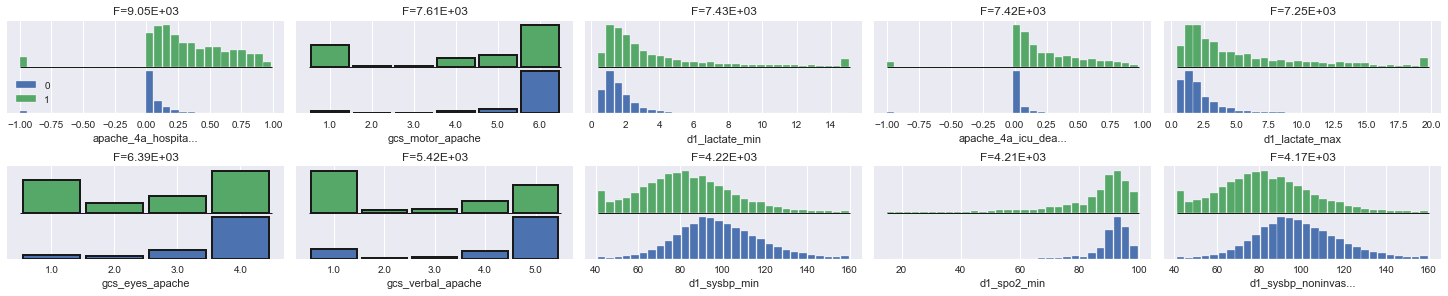

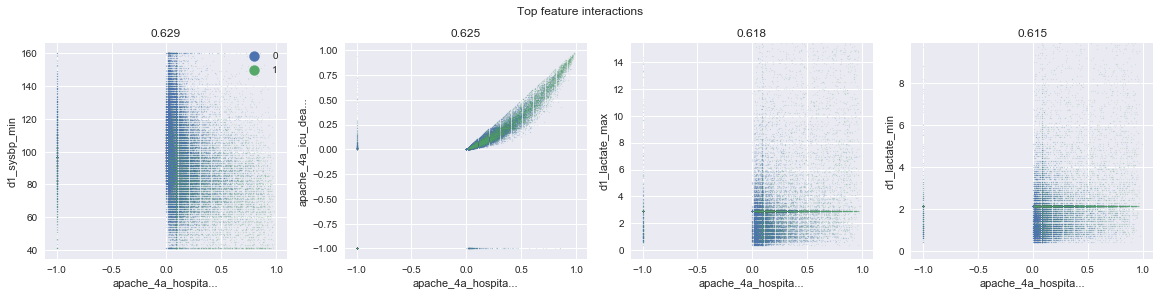

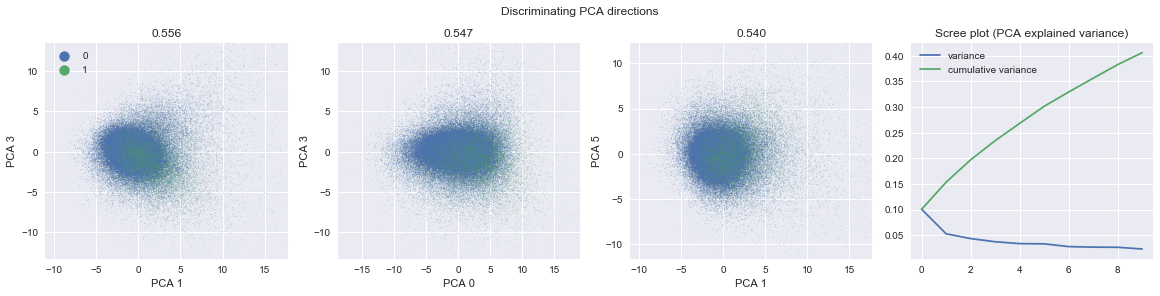

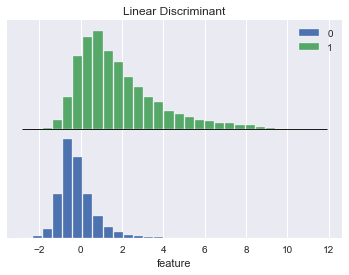

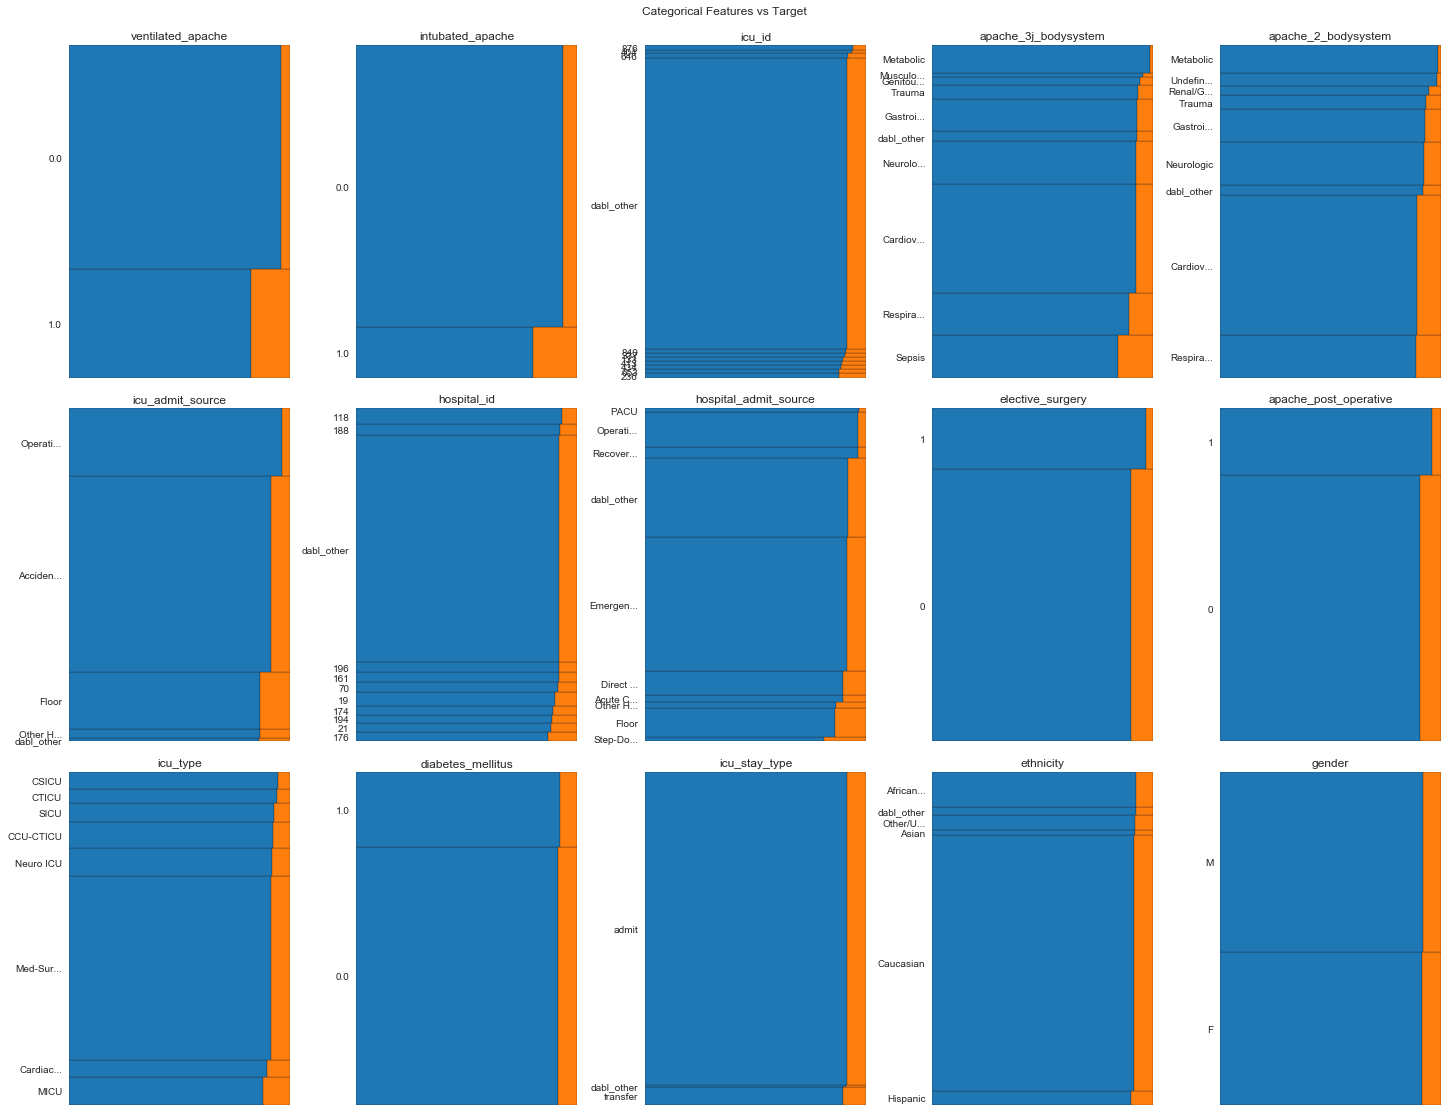

In [133]:
dabl.plot(df, target_col="hospital_death")


In [134]:
df_clean = dabl.clean(df, verbose=1)

Detected feature types:
170 float, 8 int, 8 object, 0 date, 0 other
Interpreted as:
continuous      160
dirty_float       0
low_card_int      2
categorical      14
date              0
free_string       0
useless          10
dtype: int64


In [135]:
types = dabl.detect_types(df_clean)
print(types) 

                               continuous  dirty_float  low_card_int  \
encounter_id                         True        False         False   
patient_id                           True        False         False   
hospital_id                         False        False          True   
hospital_death                      False        False         False   
age                                  True        False         False   
...                                   ...          ...           ...   
apache_4a_hospital_death_prob        True        False         False   
apache_4a_icu_death_prob             True        False         False   
diabetes_mellitus                   False        False         False   
apache_3j_bodysystem                False        False         False   
apache_2_bodysystem                 False        False         False   

                               categorical   date  free_string  useless  
encounter_id                         False  False        Fals

In [136]:
ec = dabl.SimpleClassifier(random_state=0).fit(df, target_col="hospital_death") 


Running DummyClassifier(strategy='prior')
accuracy: 0.914 average_precision: 0.086 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.477
=== new best DummyClassifier(strategy='prior') (using recall_macro):
accuracy: 0.914 average_precision: 0.086 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.477

Running GaussianNB()
accuracy: 0.194 average_precision: 0.095 roc_auc: 0.548 recall_macro: 0.538 f1_macro: 0.193
=== new best GaussianNB() (using recall_macro):
accuracy: 0.194 average_precision: 0.095 roc_auc: 0.548 recall_macro: 0.538 f1_macro: 0.193

Running MultinomialNB()
accuracy: 0.884 average_precision: 0.365 roc_auc: 0.828 recall_macro: 0.684 f1_macro: 0.667
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.884 average_precision: 0.365 roc_auc: 0.828 recall_macro: 0.684 f1_macro: 0.667

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.812 average_precision: 0.211 roc_auc: 0.755 recall_macro: 0.755 f1_macro: 0.637
=== new best DecisionTreeClas

## 7. AutoViz

In [137]:
!pip install autoviz


In [138]:
!pip install xgboost

In [139]:
# Instantiate the library
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

In [140]:
sep = '\,'
target = 'hospital_death'
# datapath = './input/'
filename = r'C:\Users\Anthony\Documents\GitHub\WIDS\Kaggle_WIDS\input\training_v2.csv'
df1 = pd.read_csv(filename,sep=sep,index_col=None)
# df1 = df.sample(frac=1.0,random_state=42)
print(df.shape)
df.head()

(91713, 186)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [141]:
dft = AV.AutoViz(filename, sep=sep, depVar='hospital_death', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=3000,max_cols_analyzed=10)

Shape of your Data Set: (91713, 186)
Classifying variables in data set...
    185 Predictors classified...
        This does not include the Target column(s)
    9 variables removed since they were ID or low-information variables
Since Number of Rows in data 91713 exceeds maximum, randomly sampling 3000 rows for EDA...
141 numeric variables in data exceeds limit, taking top 10 variables
Number of numeric variables = 141
    Number of variables removed due to high correlation = 30 
    Adding 35 categorical variables to reduced numeric variables  of 111
Selected No. of variables = 146 
Finding Important Features...
Not able to read or load file. Please check your inputs and try again...


In [142]:
titanic_filename = r'C:\Users\Anthony\Documents\Data\titanic\train.csv'

In [143]:
titanic = pd.read_csv(titanic_filename)

In [144]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Shape of your Data Set: (891, 12)
Classifying variables in data set...
    11 Predictors classified...
        This does not include the Target column(s)
    4 variables removed since they were ID or low-information variables
    List of variables removed: ['Pclass', 'Name', 'Ticket', 'Cabin']
Total Number of Scatter Plots = 3
Could not draw Pivot Charts against Dependent Variable
All plots done
Time to run AutoViz (in seconds) = 2.952


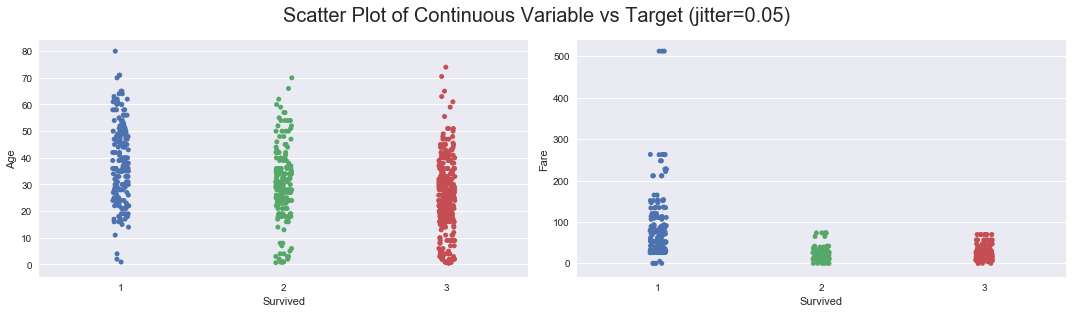

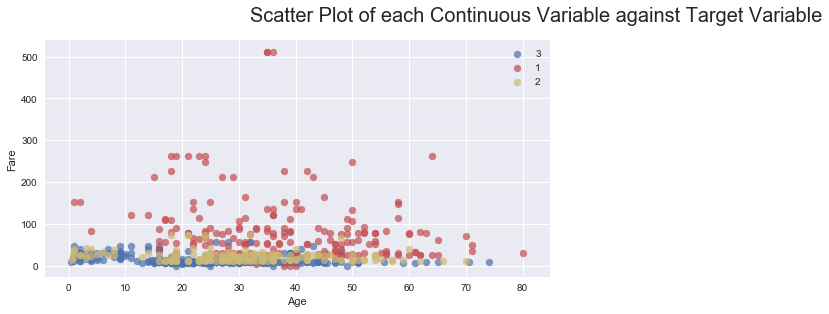

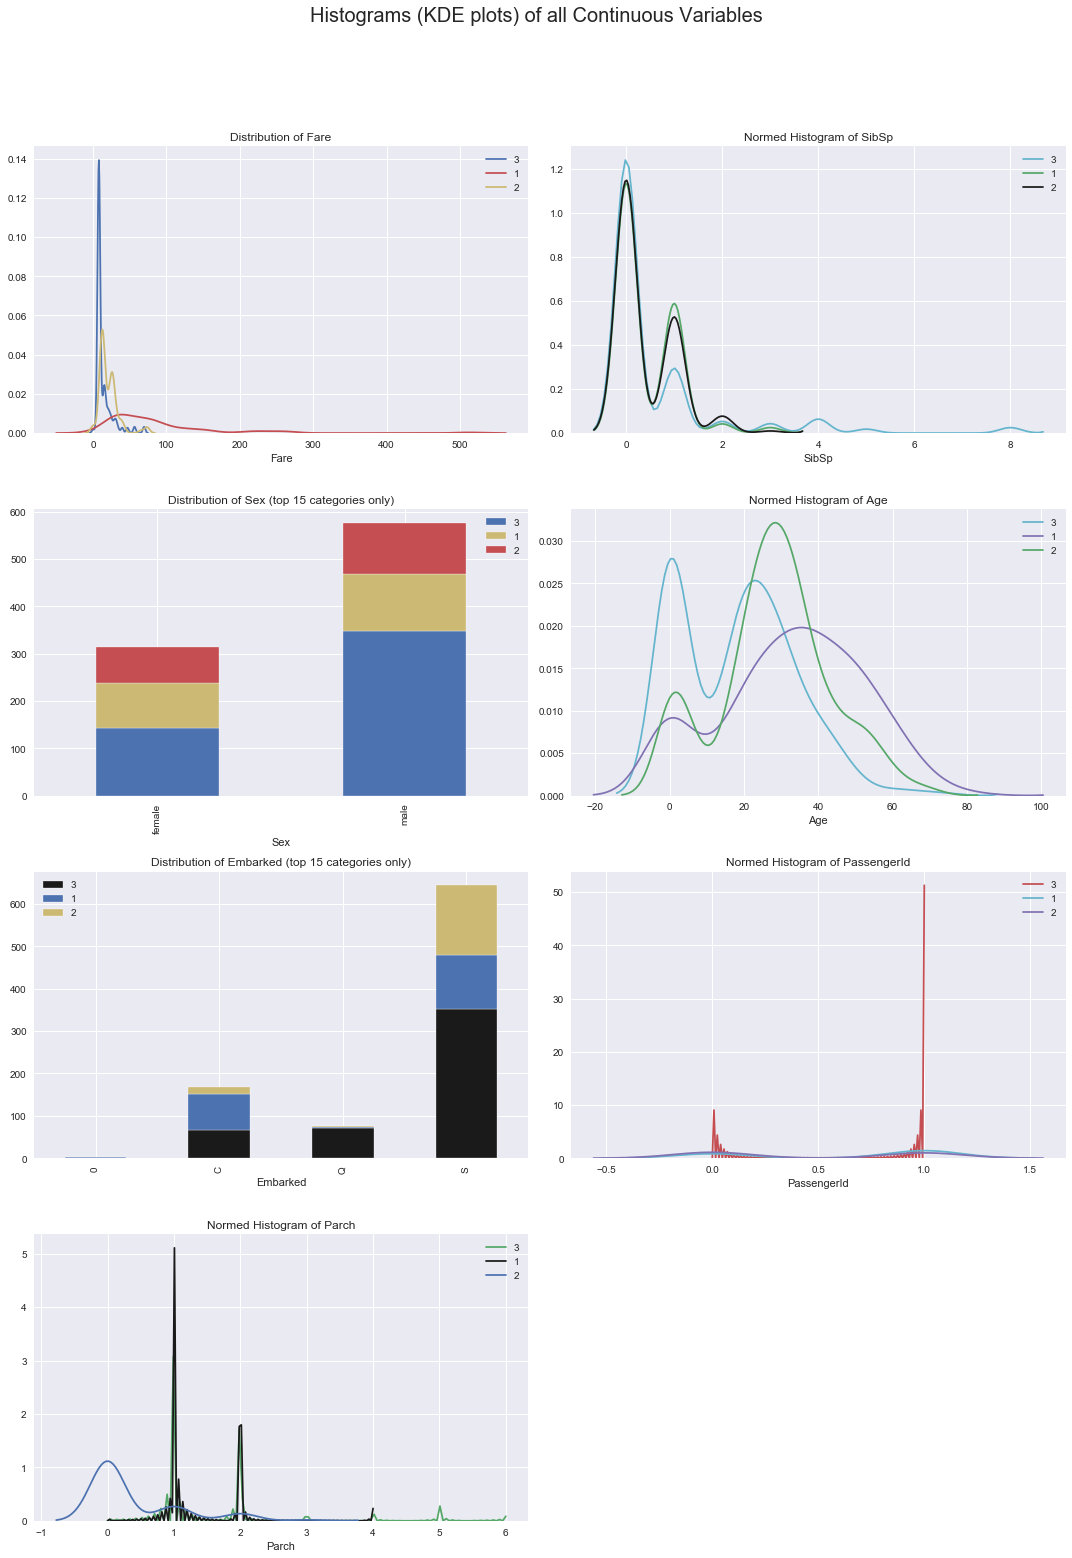

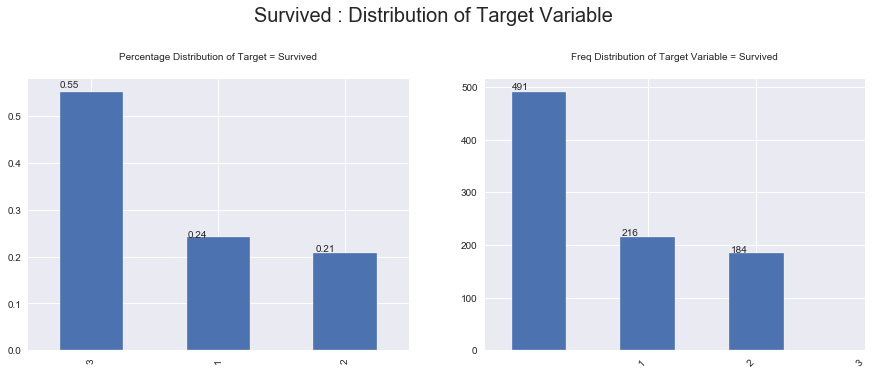

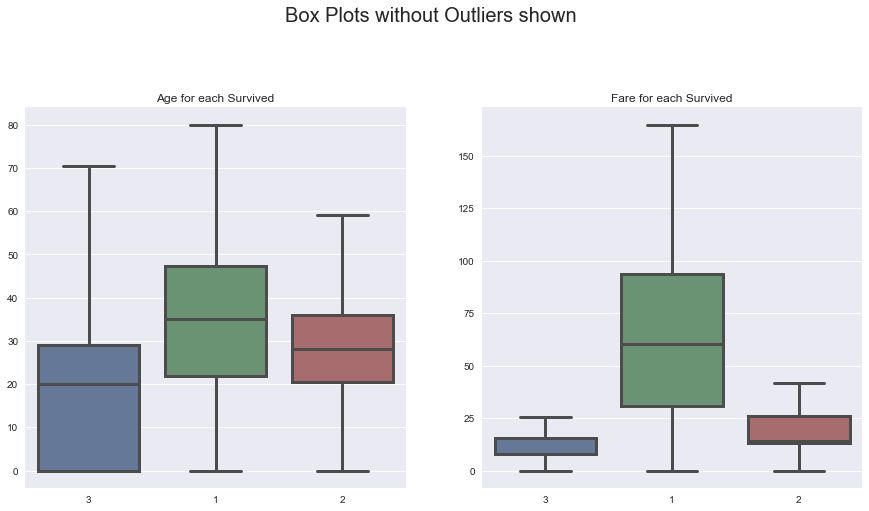

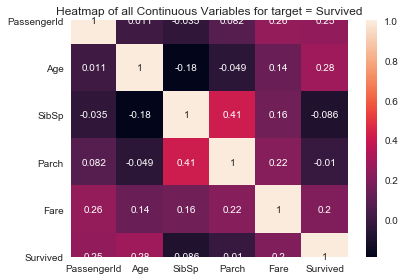

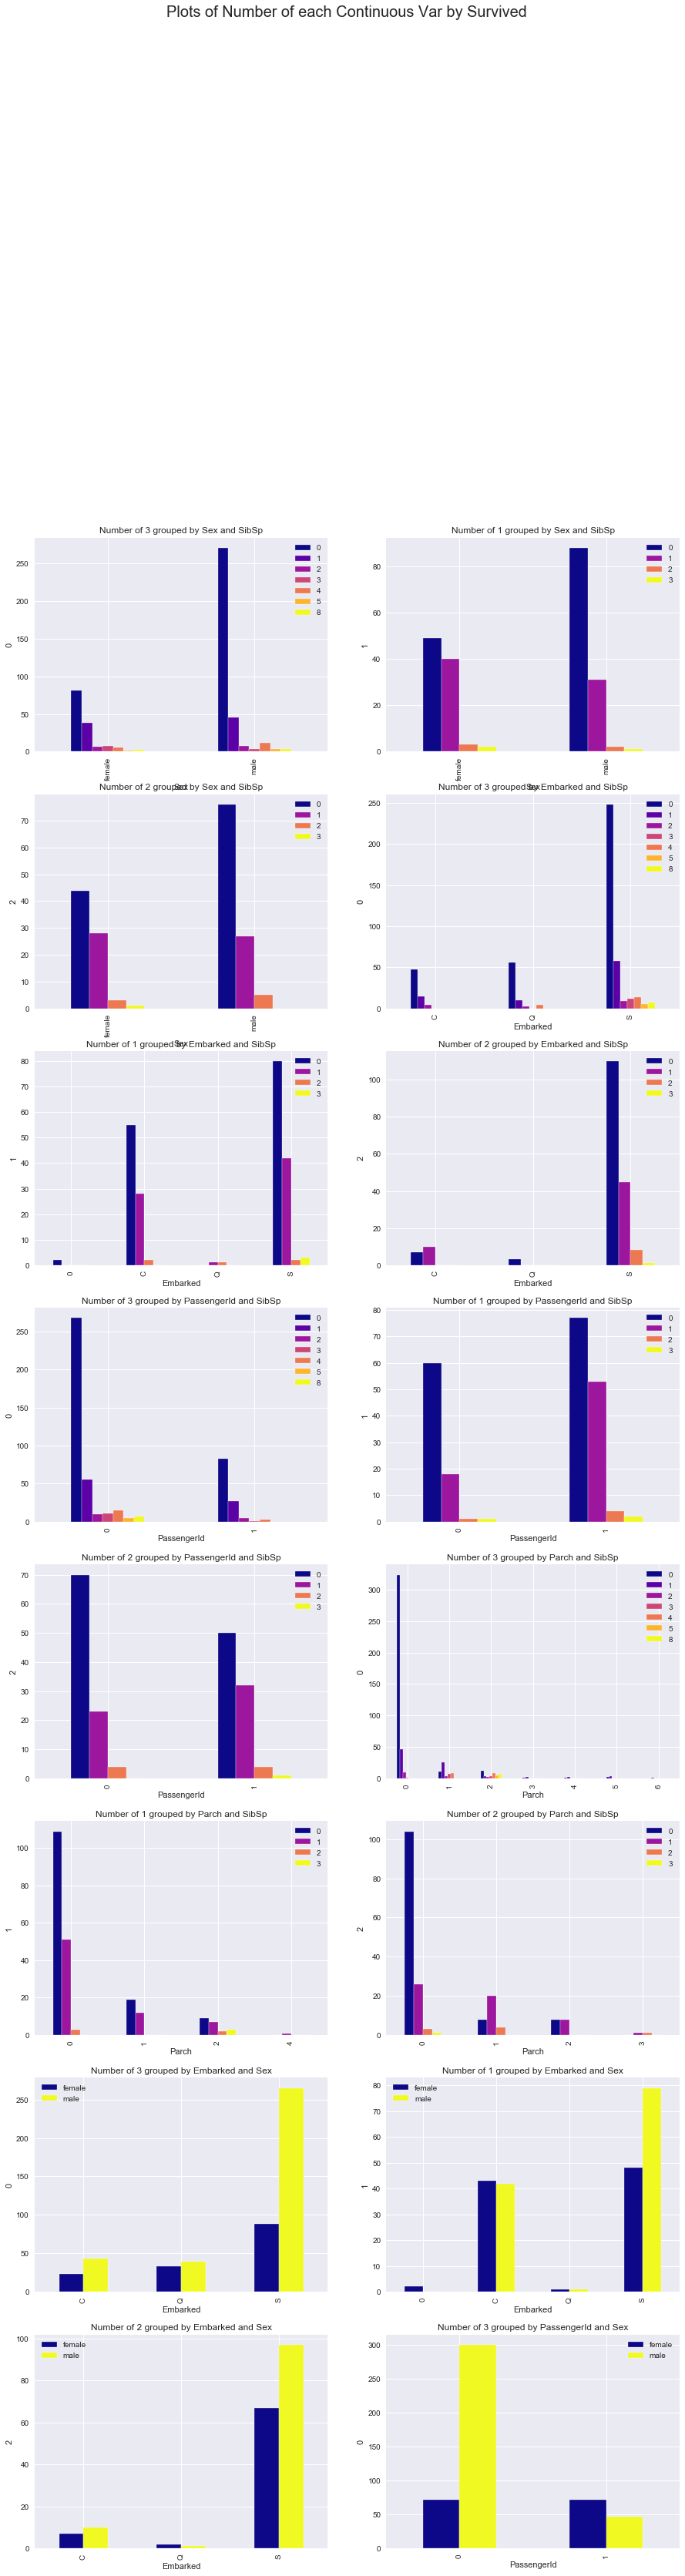

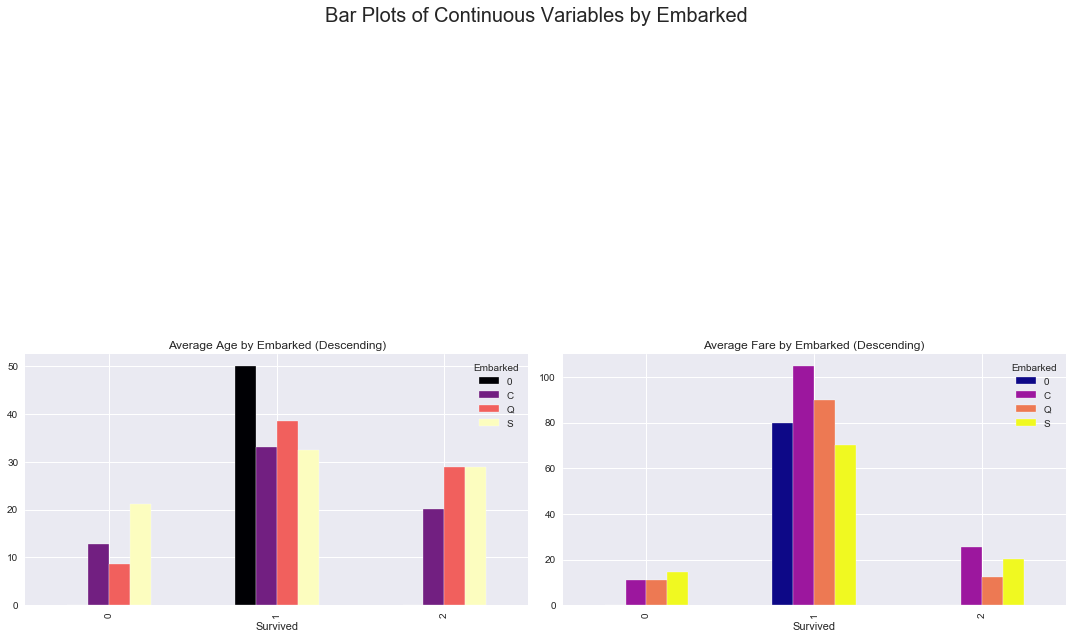

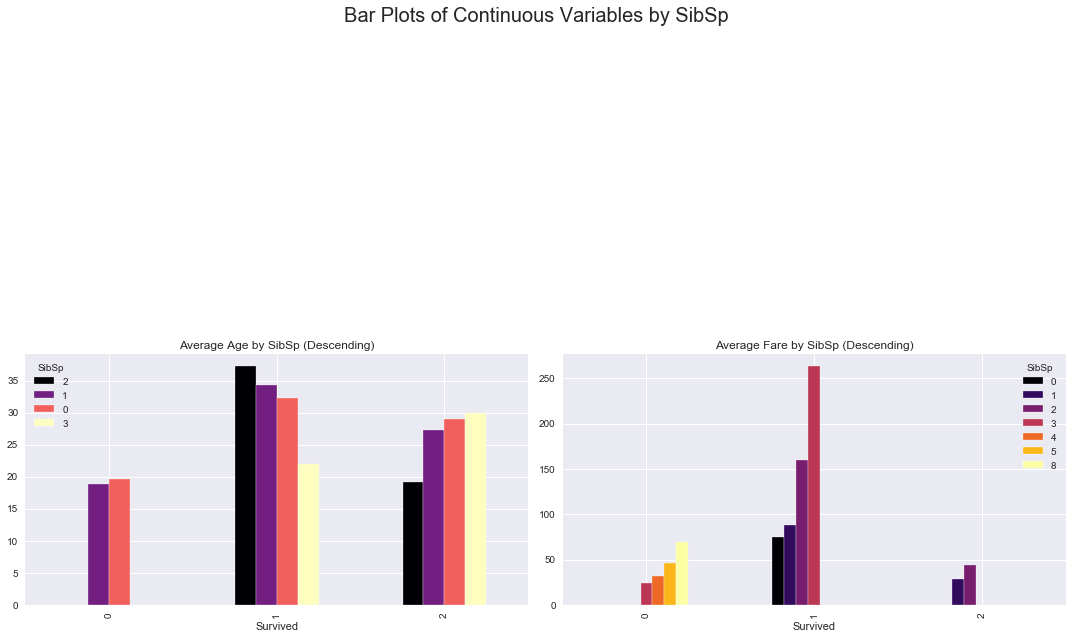

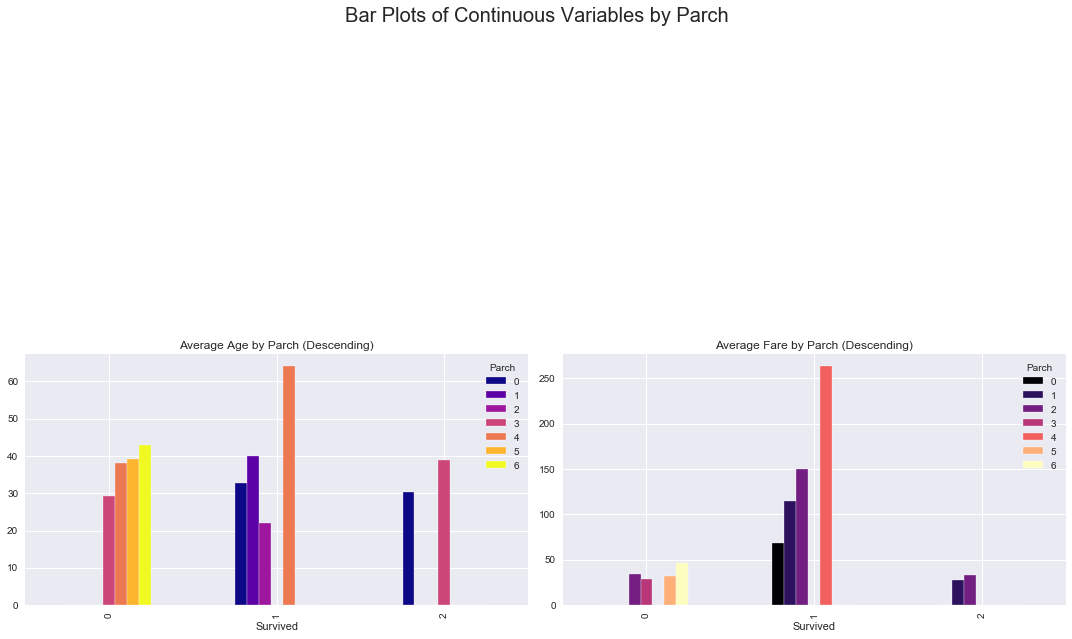

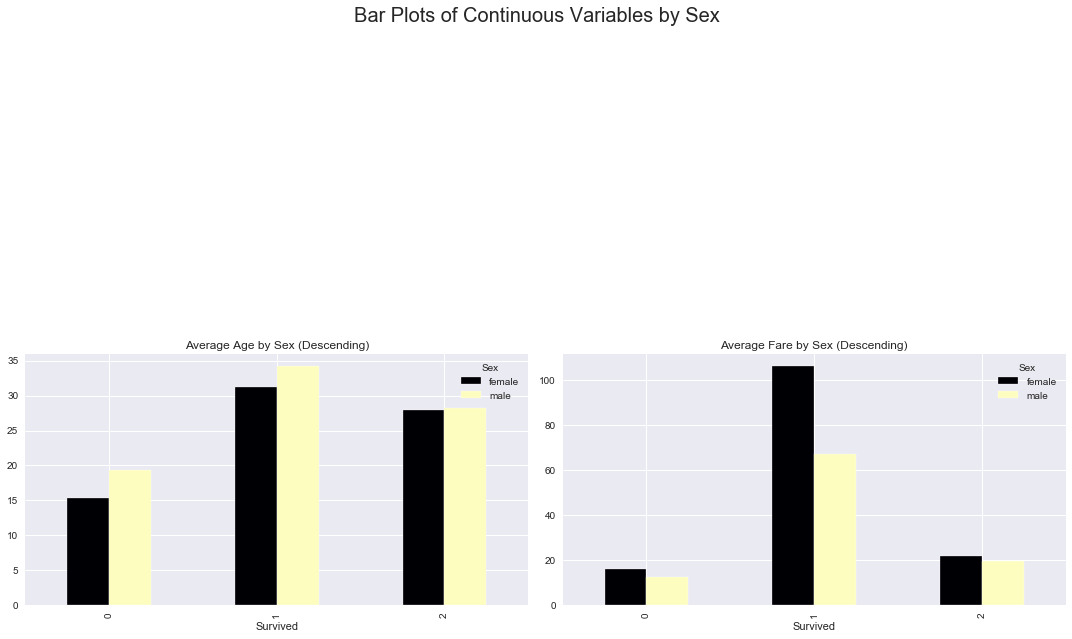

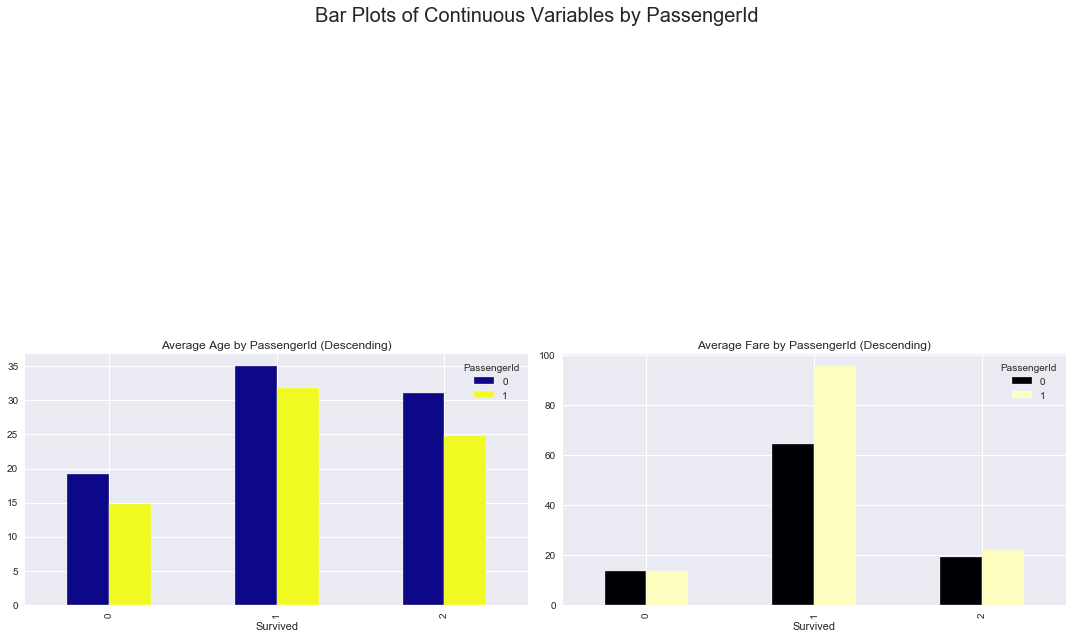

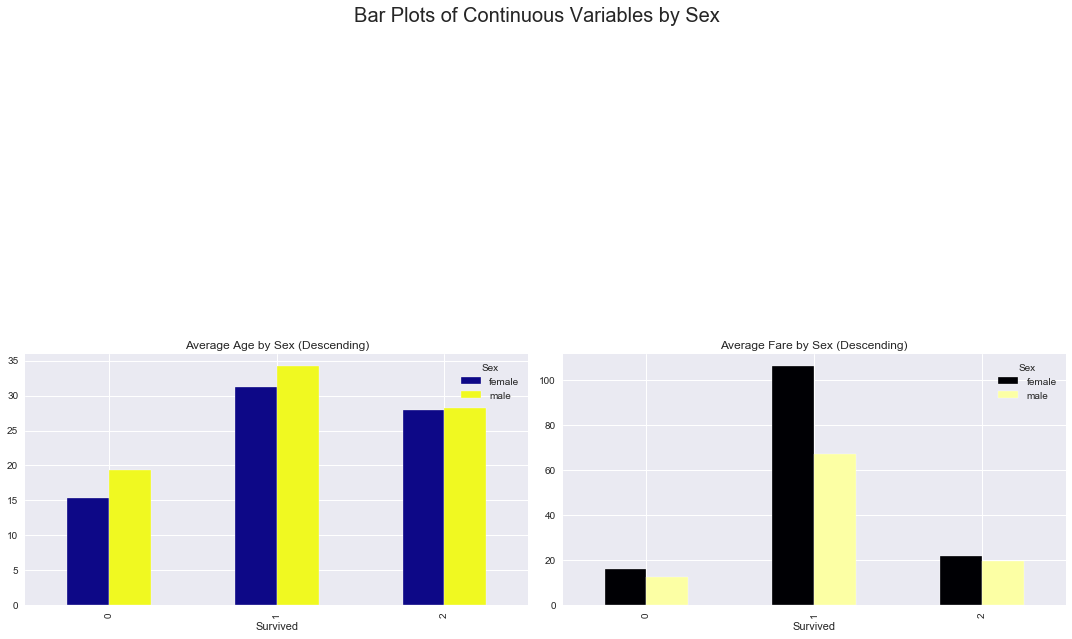

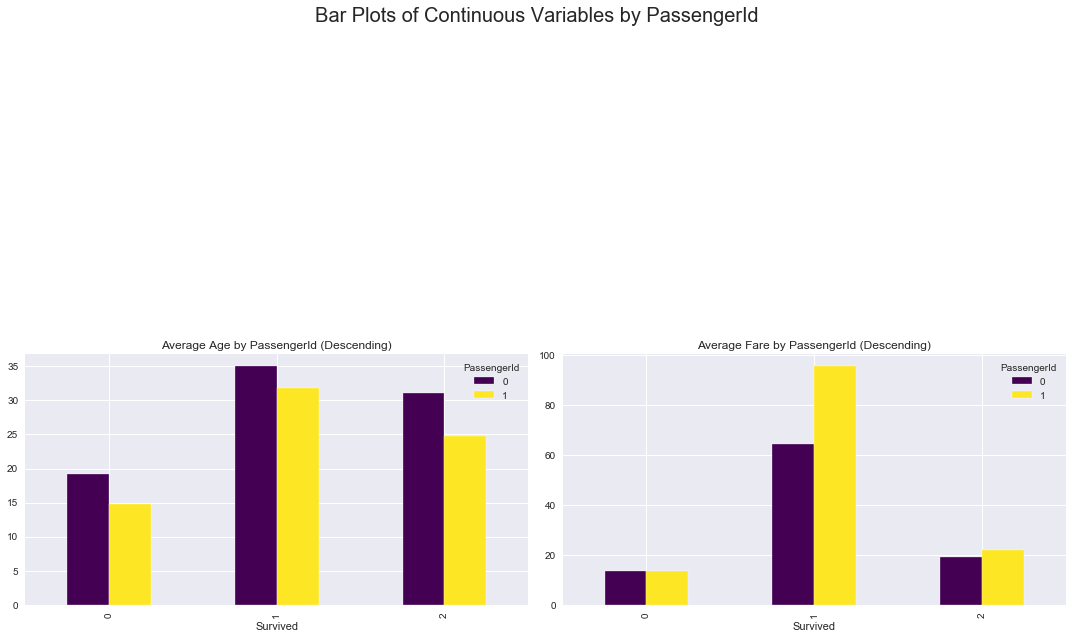

In [146]:
dft = AV.AutoViz(titanic_filename, sep=sep, depVar='Survived', dfte=None, header=0, verbose=2,
                            lowess=False,chart_format='svg',max_rows_analyzed=5000,max_cols_analyzed=10)